Question: Given a show's name and synopsis, predict the score of the show

Steps
1. Read in dataset
2. Remove punctuation and common words (stopwords) - Could round shows up or down depending on the rating
3. Convert text to lower and sort words
4. ML models + evaluation

In [3]:
import nltk
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import spacy # python -m spacy download en_core_web_lg
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
file_name = "anime_dataset_2023.csv"
global_dir = "/workspaces/anime-predictor/" # Change this to whatever global directory
anime_dataset = pd.read_csv(global_dir + f"data/{file_name}")
anime_dataset = anime_dataset.replace("UNKNOWN", None).dropna(axis = 0)
anime_dataset.dropna(how="any", inplace=True, axis=1)

anime_dataset.head()

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,"Apr 3, 1998 to Apr 24, 1999",...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,"Apr 1, 1998 to Sep 30, 1998",...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,"Jul 3, 2002 to Dec 25, 2002",...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,"Sep 30, 2004 to Sep 29, 2005",...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...
6,16,Hachimitsu to Clover,Honey and Clover,ハチミツとクローバー,8.0,"Comedy, Drama, Romance","Yuuta Takemoto, a sophomore at an arts college...",TV,24.0,"Apr 15, 2005 to Sep 27, 2005",...,J.C.Staff,Manga,23 min per ep,PG-13 - Teens 13 or older,589.0,862,4136,81747.0,260166,https://cdn.myanimelist.net/images/anime/1301/...


In [5]:
"""
Columns to keep (NLP Project): English name, score, synopsis
Can do other analysis of how different variables affect the score of a show
"""

'\nColumns to keep (NLP Project): English name, score, synopsis\nCan do other analysis of how different variables affect the score of a show\n'

In [6]:
def label_shows(row):
    if float(row["Score"]) >= 6.5:
        return "recommend"    
    return "don't recommend"

In [7]:
anime_nlp = anime_dataset[['Name', 'Score', 'Synopsis']]
anime_nlp["Label"] = anime_nlp.apply(label_shows, axis = 1)
anime_nlp['label_num'] = anime_nlp["Label"].map({"don't recommend":0, 'recommend':1})
anime_nlp['summary_len'] = anime_nlp["Synopsis"].apply(len)

anime_nlp.head()

/tmp/ipykernel_35686/3167081893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_nlp["Label"] = anime_nlp.apply(label_shows, axis = 1)
/tmp/ipykernel_35686/3167081893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_nlp['label_num'] = anime_nlp["Label"].map({"don't recommend":0, 'recommend':1})
/tmp/ipykernel_35686/3167081893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,Name,Score,Synopsis,Label,label_num,summary_len
0,Cowboy Bebop,8.75,"Crime is timeless. By the year 2071, humanity ...",recommend,1,1004
2,Trigun,8.22,"Vash the Stampede is the man with a $$60,000,0...",recommend,1,1006
3,Witch Hunter Robin,7.25,Robin Sena is a powerful craft user drafted in...,recommend,1,388
4,Bouken Ou Beet,6.94,It is the dark century and the people are suff...,recommend,1,721
6,Hachimitsu to Clover,8.0,"Yuuta Takemoto, a sophomore at an arts college...",recommend,1,847


## Data Cleaning

In [8]:
# Replacing UNKNOWN with null values (will remove those entries from the dataset)
anime_nlp = anime_nlp.replace("UNKNOWN", None).dropna(axis = 0)
anime_nlp = anime_nlp.sort_values("Score", ascending = False).reset_index().drop("index", axis = 1)

Text(0.5, 0, 'Summary Length')

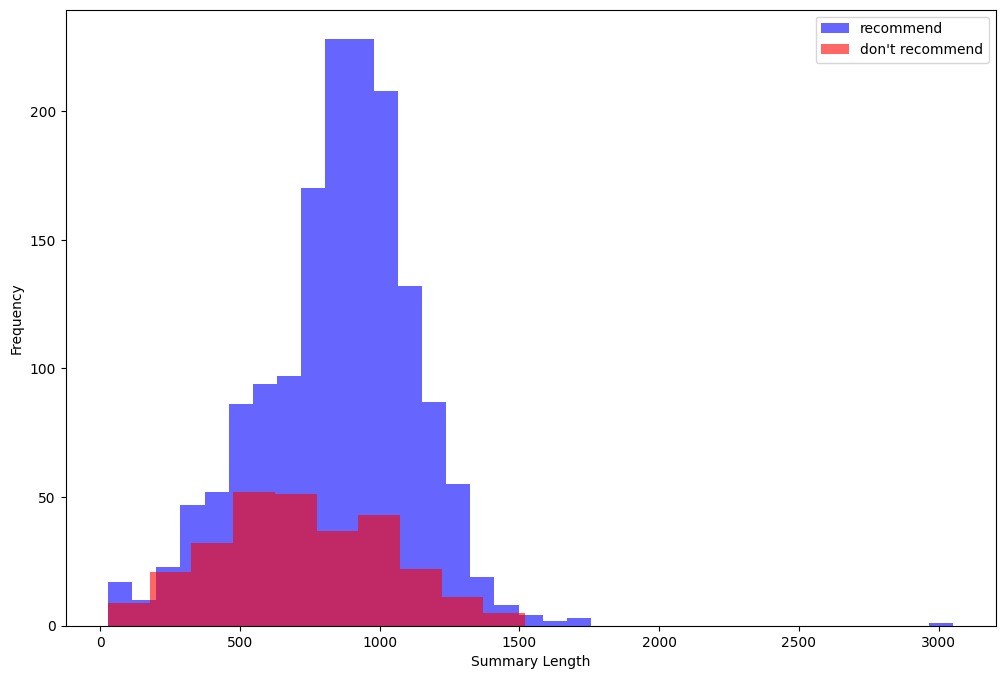

In [9]:
plt.figure(figsize=(12, 8))

anime_nlp[anime_nlp.Label=='recommend'].summary_len.plot(bins=35, kind='hist', color='blue', 
                                       label='recommend', alpha=0.6)
anime_nlp[anime_nlp.Label=="don't recommend"].summary_len.plot(kind='hist', color='red', 
                                       label="don't recommend", alpha=0.6)
plt.legend()
plt.xlabel("Summary Length")

In [10]:
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_lg')

def remove_keywords(row):
    word_tokens = word_tokenize(str(row))
    filtered_sentence = [w.lower() for w in word_tokens if w.isalpha() and w.lower() not in stop_words] # Removing stop words from sentence
    doc = nlp(' '.join(filtered_sentence).lower())
    proper_noun = [str(tok) for tok in doc if tok.pos_=='PROPN']
    # Removes better than nltk but removes a couple words that are not a PROPN
    key_words = [word.lemma_ for word in doc if word not in proper_noun]
    key_words = " ".join(key_words)
    # Add into function and .apply for whole DataFrame
    return key_words

In [11]:
anime_nlp["cleaned_synopsis"] = anime_nlp["Synopsis"].apply(remove_keywords)
anime_nlp["cleaned_names"] = anime_nlp["Name"].apply(remove_keywords)
anime_nlp["cleaned_summary"] = anime_nlp["cleaned_names"] + " " + anime_nlp["cleaned_synopsis"]

In [12]:
anime_nlp.head()

,Name,Score,Synopsis,Label,label_num,summary_len,cleaned_synopsis,cleaned_names,cleaned_summary
0,Fullmetal Alchemist: Brotherhood,9.1,After a horrific alchemy experiment goes wrong...,recommend,1,1137,horrific alchemy experiment go wrong elric hou...,fullmetal alchemist brotherhood,fullmetal alchemist brotherhood horrific alche...
1,Bleach: Sennen Kessen-hen,9.07,Substitute Soul Reaper Ichigo Kurosaki spends ...,recommend,1,972,substitute soul reaper ichigo kurosaki spend d...,bleach sennen,bleach sennen substitute soul reaper ichigo ku...
2,Steins;Gate,9.07,Eccentric scientist Rintarou Okabe has a never...,recommend,1,1166,eccentric scientist rintarou okabe thirst scie...,steins gate,steins gate eccentric scientist rintarou okabe...
3,Gintama°,9.06,"Gintoki, Shinpachi, and Kagura return as the f...",recommend,1,1173,gintoki shinpachi kagura return break member y...,,gintoki shinpachi kagura return break member ...
4,Kaguya-sama wa Kokurasetai: Ultra Romantic,9.05,The elite members of Shuchiin Academy's studen...,recommend,1,919,elite member shuchiin academy student council ...,wa kokurasetai ultra romantic,wa kokurasetai ultra romantic elite member shu...


In [13]:
from collections import Counter

words = anime_nlp[anime_nlp["Label"]=='recommend']["cleaned_summary"].apply(lambda x: [word.lower() for word in x.split()])
rec_words = Counter()

for msg in words:
    rec_words.update(msg)
    
print(rec_words.most_common(50))

[('school', 897), ('world', 804), ('one', 792), ('life', 717), ('however', 680), ('girl', 680), ('new', 642), ('find', 603), ('friend', 583), ('become', 505), ('student', 494), ('take', 475), ('high', 473), ('know', 464), ('year', 439), ('day', 426), ('begin', 410), ('make', 403), ('live', 385), ('two', 375), ('must', 366), ('young', 352), ('power', 334), ('name', 327), ('time', 317), ('human', 309), ('source', 309), ('love', 303), ('club', 301), ('come', 300), ('mysterious', 290), ('way', 290), ('get', 288), ('meet', 287), ('help', 282), ('work', 279), ('call', 279), ('fight', 277), ('together', 262), ('first', 258), ('force', 256), ('man', 252), ('family', 250), ('soon', 249), ('city', 247), ('people', 247), ('member', 246), ('even', 243), ('boy', 241), ('also', 241)]


In [14]:
from collections import Counter

words = anime_nlp[anime_nlp["Label"]=="don't recommend"]["cleaned_summary"].apply(lambda x: [word.lower() for word in x.split()])
not_rec_words = Counter()

for msg in words:
    not_rec_words.update(msg)
    
print(not_rec_words.most_common(50))

[('world', 175), ('girl', 153), ('school', 126), ('one', 125), ('source', 122), ('new', 107), ('life', 101), ('become', 100), ('however', 94), ('friend', 89), ('find', 80), ('year', 71), ('begin', 66), ('name', 65), ('day', 64), ('know', 63), ('student', 62), ('power', 62), ('young', 61), ('call', 61), ('time', 60), ('meet', 60), ('take', 59), ('must', 59), ('high', 59), ('use', 56), ('human', 55), ('live', 55), ('battle', 54), ('boy', 54), ('two', 54), ('save', 53), ('people', 52), ('mysterious', 51), ('way', 51), ('get', 51), ('ann', 50), ('make', 50), ('group', 49), ('game', 46), ('earth', 46), ('family', 45), ('go', 44), ('team', 44), ('war', 43), ('together', 43), ('fight', 42), ('good', 41), ('soon', 41), ('around', 39)]


## ML Modelling

In [15]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split

# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = anime_nlp["cleaned_summary"]
y = anime_nlp["label_num"]
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1854,)
(1854,)
(1390,)
(464,)
(1390,)
(464,)


In [16]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
print(type(X_train_dtm), X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
print(type(X_test_dtm), X_test_dtm.shape)

<class 'scipy.sparse._csr.csr_matrix'> (1390, 14586)
<class 'scipy.sparse._csr.csr_matrix'> (464, 14586)


In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 91875 stored elements and shape (1390, 14586)>

In [18]:
# import and instantiate a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
nb = MultinomialNB() # Performed comparatively worse + does not have as many hyperparameters to tune compared to SVC
nb = SVC(gamma = "scale", class_weight = "balanced", C = 0.85)

In [19]:
# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(X_train_dtm, y_train)

CPU times: user 918 ms, sys: 5.02 ms, total: 923 ms
Wall time: 933 ms


SVC(C=0.85, class_weight='balanced')

In [20]:
from sklearn import metrics

# make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_pred_class, y_test))

# print the confusion matrix
print("=======Confusion Matrix===========")
metrics.confusion_matrix(y_pred_class, y_test)

=======Accuracy Score===========
0.7607758620689655
=======Confusion Matrix===========


array([[ 22,  61],
       [ 50, 331]])

In [21]:
# print message text for false positives (ham incorrectly classifier)
# X_test[(y_pred_class==1) & (y_test==0)]
X_test[y_pred_class > y_test]

1770    isuca poor shinichirou asano bad luck parent a...
1678    jikan shihaisha many class koyuki honda look f...
1579    coppelion first glance ibara naruse friend aoi...
1671    island tv remote island far mainland name uras...
1785    project scard praeter kizu siege foreign organ...
1602    kenka banchou otome girl beat boy kenka bancho...
1683    battle upon creation marble launch machine kno...
1697    togainu chi wake third world war leave japan r...
1628    ikkitousen kanto region seven high school figh...
1696    trickster edogawa ranpo shounen tanteidan yori...
1703    hidan aria aa akari mamiya student tokyo butei...
1700    dance devil ritsuka tachibana always good stud...
1804    koi koi tanaka tetsuro excite get full scholar...
1820    momo kyun sword momoko beautiful young sword f...
1846    bikini warrior darkness threaten world four he...
1829    shoumetsu toshi one day city suddenly disappea...
1748    keishichou tokumubu tokushu kyouakuhan taisaku...
1645    tokyo 

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()), 
                 ('tfid', TfidfTransformer()),  
                 ('model', SVC(gamma = "scale", class_weight = "balanced", C = 0.5, tol = 0.9))])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred))

# print the confusion matrix
print("=======Confusion Matrix===========")
metrics.confusion_matrix(y_test, y_pred)

=======Accuracy Score===========
0.7931034482758621
=======Confusion Matrix===========


array([[ 11,  61],
       [ 35, 357]])

In [23]:
file_name = "test.csv"
entry = pd.read_csv(global_dir + f"data/{file_name}")
entry["cleaned_summary"] = entry["summary"].apply(remove_keywords)
entry["cleaned_summary"]

0    solo levelling sing dub weak hunter mankind gr...
Name: cleaned_summary, dtype: object

In [24]:
test = entry["cleaned_summary"]
test_output = 1
vect_test = CountVectorizer()
vect_test.fit_transform(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
test_entry = vect_test.transform(test)

# examine the document-term matrix
print(type(X_train_dtm), X_train_dtm.shape)

print(type(test_entry), test_entry.shape)

nb.predict(test_entry) # Output array is prediction, 1 = Recommend, 0 = Not Recommend

<class 'scipy.sparse._csr.csr_matrix'> (1390, 14586)
<class 'scipy.sparse._csr.csr_matrix'> (1, 14586)


array([1])

In [25]:
import mlflow
from sklearn.metrics import mean_squared_error
from mlflow.models import infer_signature
# Start a new MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_param("gamma", "scale") # gamma = "scale", class_weight = "balanced", C = 0.5, tol = 0.9
    mlflow.log_param("class_weight", "balanced")
    mlflow.log_param("C", 0.5)
    mlflow.log_param("tol", 0.9)
    # Train the model on the training data
    nb.fit(X_train_dtm, y_train)
    # Make predictions on the testing data
    predictions = nb.predict(X_test_dtm)
    # Calculate the MSE of the predictions
    mse = mean_squared_error(y_test, predictions)
    # Log the metric
    # mlflow.log_metric("mse", mse)
    # # Log the model artifact
    # mlflow.sklearn.log_model(nb, "model")
    # mlflow.sklearn.save_model(nb, "model")
    # # Print the MSE of the predictions
    # print("Mean Squared Error:", mse)
    signature = infer_signature(X_test, y_pred)

    # Log parameters and metrics using the MLflow APIs
    # mlflow.log_params(params)
    mlflow.log_metrics({"mse": mean_squared_error(y_test, y_pred)})

    # Log the sklearn model and register as version 1
    mlflow.sklearn.log_model(
        sk_model=nb,
        artifact_path="sklearn-model",
        signature=signature,
        registered_model_name="sk-learn-svc-model",
    )
    # End the MLflow run
    # mlflow.end_run()

Registered model 'sk-learn-svc-model' already exists. Creating a new version of this model...
Created version '2' of model 'sk-learn-svc-model'.


In [26]:
result = mlflow.register_model(
    "runs:/6b93d7ec436a4984b079be44ad0a6b93", "sk-learn-svc"
)

Registered model 'sk-learn-svc' already exists. Creating a new version of this model...
Created version '2' of model 'sk-learn-svc'.


In [ ]:
# from mlflow import MlflowClient

# client = MlflowClient()
# client.create_registered_model("sk-learn-svc-anime_model")